<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/Basic_Conversational_Agent_With_Memory_Langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U langgraph

In [3]:
pip install langchain_core langchain-anthropic langgraph langchain-openai

  Using cached langchain_anthropic-0.3.12-py3-none-any.whl.metadata (1.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.3 MB/s eta 0:00:00


In [5]:
!pip install -U langchain-tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 142.3 MB/s eta 0:00:00


In [6]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
# from google.colab import userdata
# userdata.get('TAVILY_API_KEY')
# from google.colab import userdata
# openai_apikey = userdata.get('OPENAI_API_KEY')

TAVILY_API_KEY: ··········


In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [8]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearch(max_results=2)
tools = [tool]
llm = init_chat_model("openai:gpt-3.5-turbo-0125", max_tokens=50)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [9]:
graph = graph_builder.compile(checkpointer=memory)

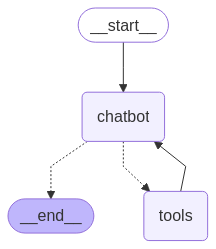

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str, config: dict[str, dict[str, str]]):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config = config):
        print("EVENT")
        print(event)
        print("--------------")
        for value in event.values():
            print("VALUE")
            print(value)
            print("--------------")
            print("Assistant:", value["messages"][-1].content)


In [14]:
config = {"configurable": {"thread_id": "2"}}

In [15]:
# user_input = "Hi there! My name is Will."

# # The config is the **second positional argument** to stream() or invoke()!
# events = graph.stream(
#     {"messages": [{"role": "user", "content": user_input}]},
#     config,
#     stream_mode="values",
# )
# for event in events:
#     event["messages"][-1].pretty_print()

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input, config)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input, config)
        break

User: langgraph
EVENT
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9Jq2My4eLVkvMcGLBrroUsW7', 'function': {'arguments': '{"query":"LangGraph","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 809, 'total_tokens': 832, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BSixy4toXLdETFED80M7hbjX4fCsK', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cc1530b6-752d-400c-ad22-066cf5565c5e-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LangGraph', 'search_depth': 'advanced'}, 'id': 'call_9Jq2My4eLVkvMcGLBrroUsW7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 8